In [24]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import pandas as pd
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms#

In [4]:
from avgn.visualization.projections import scatter_spec, scatter_projections
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [5]:
DATASET_ID = 'swamp_sparrow'

In [6]:
syllable_df = pd.read_pickle(DATA_DIR / 'embeddings' / DATASET_ID / 'full-taper.pickle')

In [7]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,rate,f_start,f_end,spectrogram,syll_len,umap,umap_0.5,umap_0.25
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1,44100,8656.347656,4651.171875,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.014490,"[-2.096019744873047, -0.9222933053970337]","[2.175920248031616, 4.7172160148620605]","[2.175920248031616, 4.7172160148620605]"
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1,44100,7708.886719,4005.175781,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.063492,"[3.529989242553711, -3.917405605316162]","[5.820304870605469, -5.972965717315674]","[5.820304870605469, -5.972965717315674]"
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1,44100,6244.628906,5900.097656,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.010998,"[-1.1466008424758911, 0.38041141629219055]","[5.621817588806152, 5.74241828918457]","[5.621817588806152, 5.74241828918457]"


In [8]:
len(syllable_df.indv.unique())

615

In [9]:
### get population info

In [10]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [11]:
DATASET_ID = 'swamp_sparrow'
hparams = HParams()
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.3s


[Parallel(n_jobs=-1)]: Done 1867 out of 1867 | elapsed:    6.6s finished


In [12]:
population = [
    str(i)
    for i in np.array(
        [
            dataset.data_files[key].data["POPID"] if key in dataset.data_files else None
            for key in tqdm(syllable_df.key.values)
        ]
    )
]
np.unique(population)

array(['Adirondacks, NY', 'Conneaut, PA', 'Horicon, WI',
       'Hudson Valley, NY', 'Montezuma, NY', 'Waterloo, MI'], dtype='<U17')

In [13]:
syllable_df['population'] = population

In [14]:
mask = syllable_df.population != 'None'
syllable_df = syllable_df[mask]

In [15]:
specs = np.stack(syllable_df['spectrogram'].values)
embedding = np.vstack(syllable_df['umap'].values)
#embedding = np.vstack(syllable_df['umap_0.5'].values)

In [16]:
np.shape(embedding)

(97528, 2)

In [17]:
syllable_df['f_diff'] = syllable_df['f_start'].values - syllable_df['f_end'].values

In [18]:
syllable_df['syll_len'] = syllable_df['syll_len']*1000

In [19]:
syllable_df['syll_len'][:5]

0    14.489796
1    63.492063
2    10.997732
3    82.494331
4    13.990930
Name: syll_len, dtype: float64

In [20]:
embedding = np.vstack([
    syllable_df['syll_len'] + np.random.rand(len(syllable_df['syll_len'])),
    syllable_df['f_diff'].values + np.random.rand(len(syllable_df['f_diff'])),
]).T

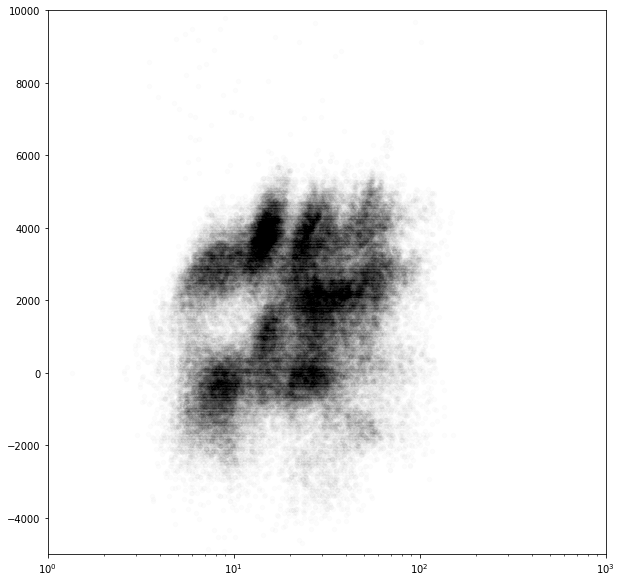

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0],embedding[:,1],  alpha = 0.01, s=20, color='k')
ax.set_xlim([1, 1000])
ax.set_ylim([-5000, 10000])
ax.set_xscale('log')

In [22]:
embedding[:,0] = np.log(embedding[:,0])

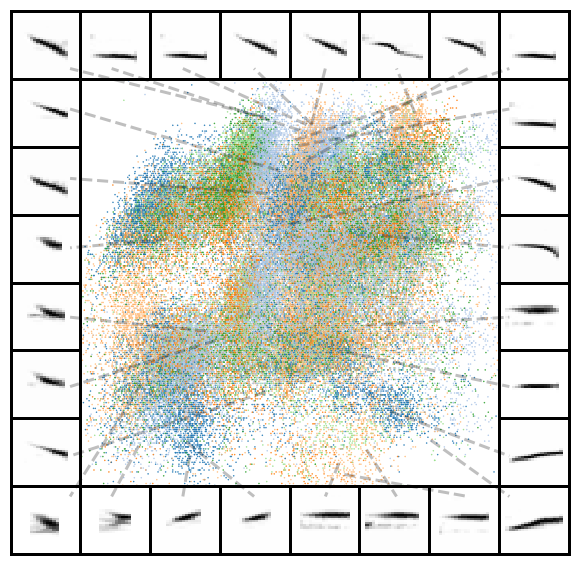

In [23]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df.population.values[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

### UMAP for a single community

In [25]:
subset_df = syllable_df[syllable_df.population == 'Conneaut, PA']

In [28]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

cuml_umap = cumlUMAP()
umap_embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  import sys


In [36]:
embedding = np.vstack([
    np.log(subset_df['syll_len'] + np.random.rand(len(subset_df['syll_len']))),
    subset_df['f_diff'].values + np.random.rand(len(subset_df['f_diff'])),
]).T

In [46]:
pos = subset_df['pos_in_syllable'].values[:nex]
pos[pos>8 ]= 9

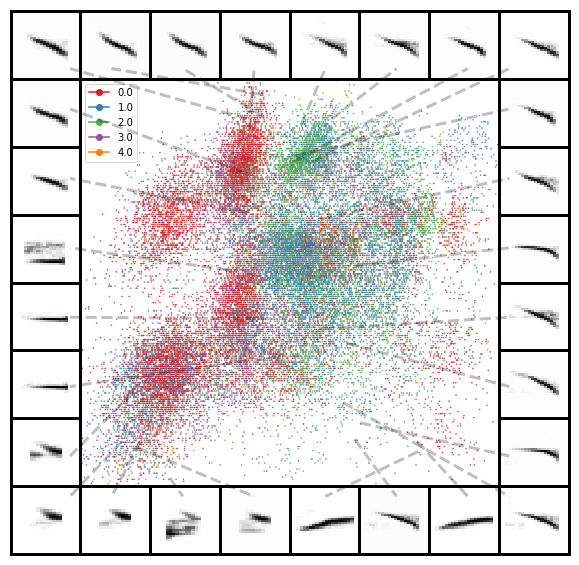

In [47]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

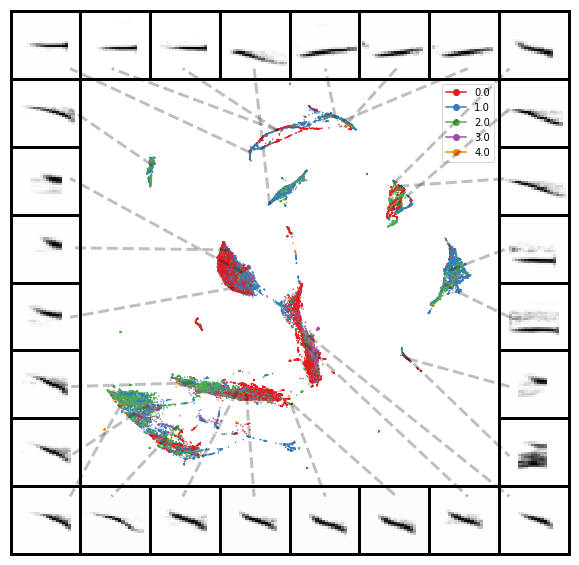

In [48]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

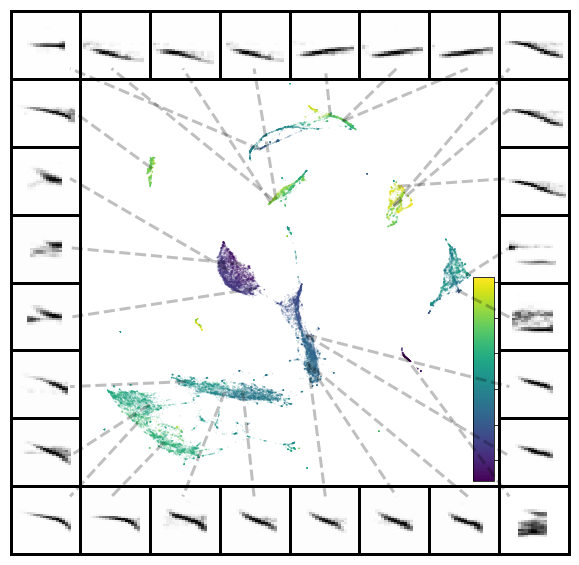

In [49]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': np.log(subset_df['syll_len'].values[:nex]), #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


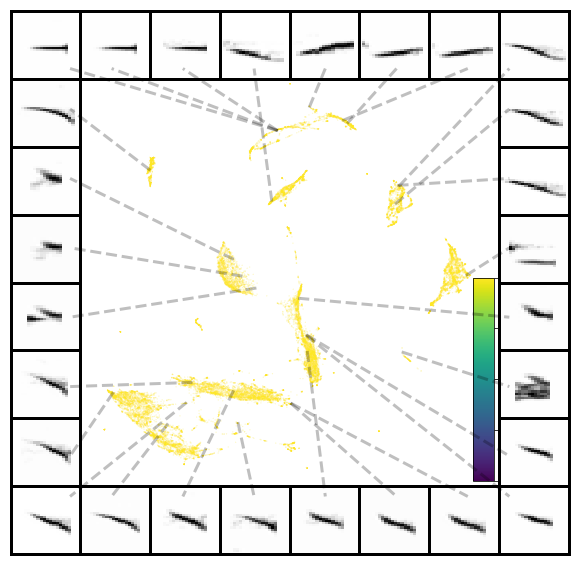

In [50]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': subset_df['f_diff'].values[:nex], #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

### mask everything 

In [23]:
mask = syllable_df.population == 'Conneaut, PA'# 'Hudson Valley, NY'

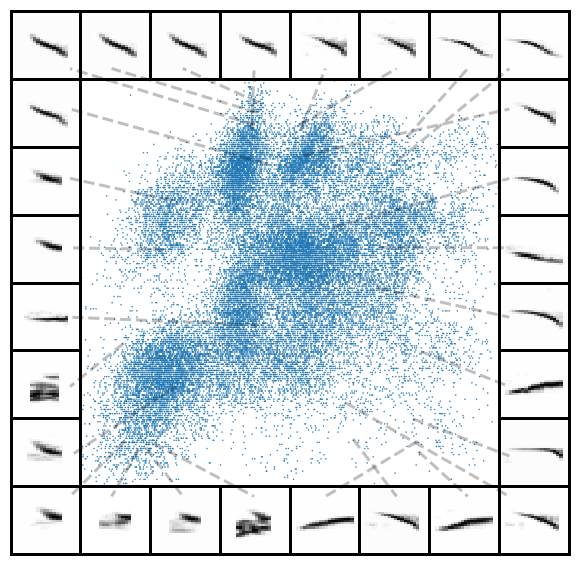

In [24]:
nex = -1
scatter_spec(
    embedding[mask][:nex],
    specs[mask][:nex],
    column_size=8,
    #x_range = [np.log(1), np.log(1000)],
    #y_range = [-3000,7000],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df[mask].population.values[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': False,
        'log_x':False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

In [25]:
def remove_outliers(z, pct = 99.5):
    """ GPU based UMAP algorithm produces some outliers that UMAP does not, but is much faster
    this is a quick fix for that. 
    """
    _min = np.percentile(z, (100-pct), axis=0)
    _max = np.percentile(z, pct, axis=0)
    for col in range(np.shape(z)[1]):
        mask = z[:,col] < _min[col]
        z[mask,col] = _min[col]
        mask = z[:,col] > _max[col]
        z[mask,col] = _max[col]
    return z

In [26]:
embedding = np.vstack(syllable_df['umap'].values)

In [27]:
#embedding[:,0] = embedding[:,0]*-1

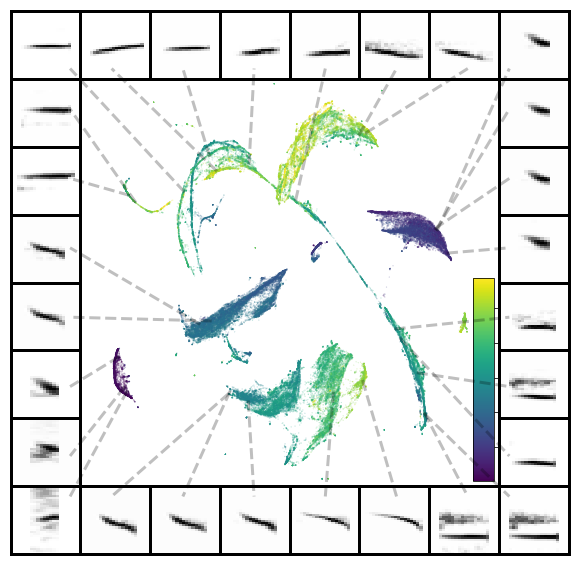

In [28]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': np.log(syllable_df['syll_len'].values[:nex]), #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

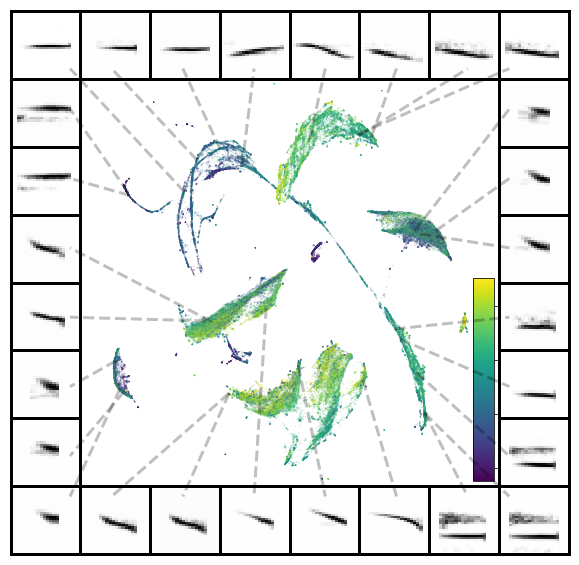

In [29]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df['f_diff'].values[:nex], #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

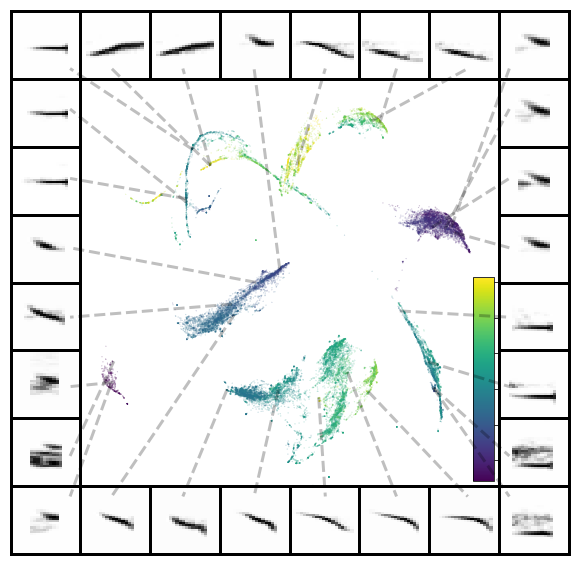

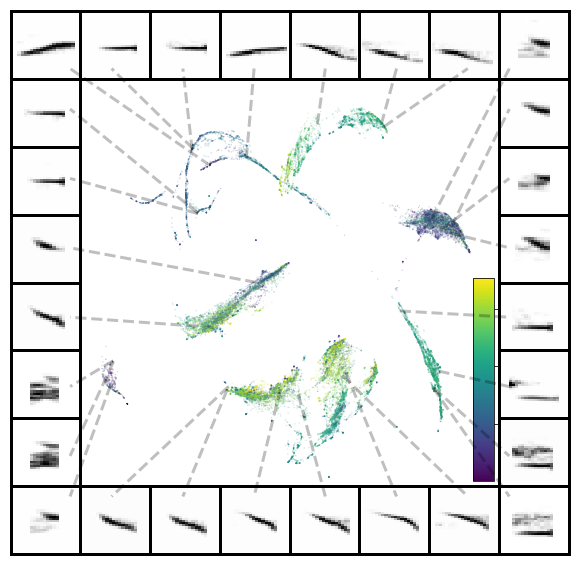

In [30]:
mask = syllable_df.population == 'Conneaut, PA'# 'Hudson Valley, NY'
nex = -1
scatter_spec(
    embedding[mask][:nex],
    specs[mask][:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': np.log(syllable_df[mask]['syll_len'].values[:nex]), #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

nex = -1
scatter_spec(
    embedding[mask][:nex],
    specs[mask][:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df[mask]['f_diff'].values[:nex], #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

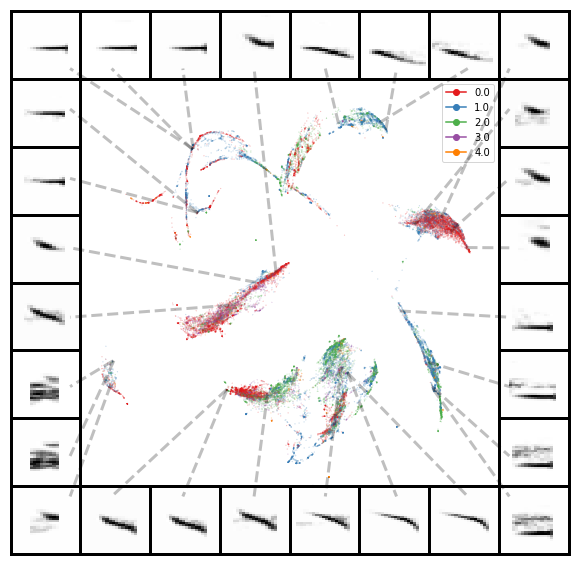

In [31]:
pos = syllable_df[mask]['pos_in_syllable'].values[:nex]
pos[pos>4 ]= 4

nex = -1
scatter_spec(
    embedding[mask][:nex],
    specs[mask][:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos, #syllable_df.labels.values[:nex],
        'categorical_labels': True,
        'color_palette': 'Set1',
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)